In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import joblib

In [9]:
qa_results = joblib.load('outputs/bert_qa_results_august_500.pkl')

In [10]:
# updated risk factors from word2vec
age_synonyms = ['age', 'younger', 'older', 'ages', 'aged', 'old']
gender_synonyms = ['gender', 'ethnicity', 'sex', 'demographics', 'occupation', 'nationality']
sex_synonyms = ['sex', 'gender', 'ethnicity', 'breed', 'race/ethnicity', 'occupation']
pneumonia_synonyms = ['pneumonia', 'pneumonias', 'tracheitis', 'croup', 'pharyngitis', 'bronchiolitis']
obesity_synonyms = ['obesity', 'diabetes', 'hypertension', 'malnutrition', 'osteoporosis', 'nafld']
diabetes_synonyms = ['diabetes', 'mellitus', 'obesity', 'hypertension', 'insulin-dependent', 'hypercholesterolemia']
smoking_synonyms = ['smoking', 'cigarette', 'smoke', 'obesity', 'abuse', 'breastfeeding']
cardiovascular_synonyms = ['cardiovascular', 'cardiopulmonary', 'cardiac', 'cerebrovascular', 'hypertension', 'musculoskeletal']
location_synonyms = ['location', 'locations', 'geographical', 'distribution', 'geographic', 'temporal']
contact_synonyms = ['contact', 'contacts', 'transmission', 'proximity', 'movement', 'exposure']
asthma_synonyms = ['asthma', 'wheezing', 'copd', 'exacerbations', 'atopy', 'wheeze']
cancer_synonyms = ['cancer', 'cancers', 'carcinoma', 'prostate', 'melanoma', 'tumour']

candidate_risk_factors = set(age_synonyms + gender_synonyms + sex_synonyms + pneumonia_synonyms + obesity_synonyms + diabetes_synonyms + smoking_synonyms + cardiovascular_synonyms + location_synonyms + contact_synonyms + asthma_synonyms + cancer_synonyms)

In [11]:
risk_factor_list=[]
for result in qa_results:
    for risk_factor in candidate_risk_factors:
        if risk_factor in result[1].split():
            risk_factor_list.append(risk_factor)

print(risk_factor_list)

[]


In [12]:
risk_factor_count = Counter(risk_factor_list)
print(risk_factor_count)

Counter()


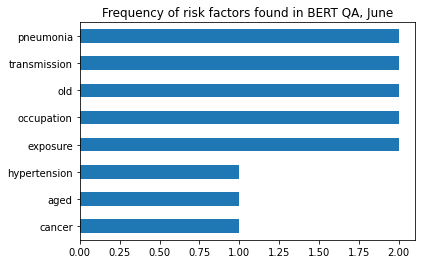

In [8]:
risk_factor_df = pd.DataFrame.from_dict(risk_factor_count, orient='index')
risk_factor_df.columns = ['count']
risk_factor_df.sort_values(by='count', ascending=True).plot(kind='barh', legend=None)
plt.title("Frequency of risk factors found in BERT QA, June")
plt.show()